The objective of this notebook is to analyze Ames Housing data and use several regression models to predict house prices.

A little background about the data. It contains almost every feature of a house in Ames, Iowa. The features consist of how many bedrooms, location, surrounding, etc. The data is from Kaggle's Housing Prices: Advanced Regression Techniques. It comes with a train set, test set, and data dictionary. (link below).

Steps to accomplish the objective:

1. Import data
2. Exploratory analysis
3. Data cleaning
4. Machine learning


# Import data

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Understanding the Data

Quick look at data

In [2]:
print train.head(10)
print train.shape

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN    NaN         NaN       0   
1         Lvl    AllPub

Check if test columns equal train columns and they do.

In [3]:
test.columns == train.columns[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

Look at the data types. Object has the highest count.

In [4]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

The distribution of the target (SalePrice)

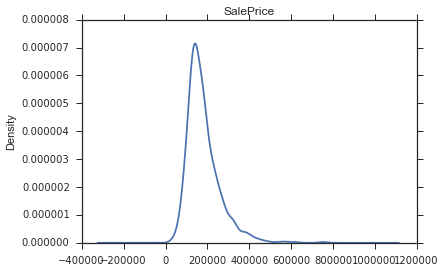

In [39]:
% matplotlib inline
import matplotlib.pyplot as plt

# plt.figure(figsize=(10,10))
# plt.hist(train['SalePrice'], bins = 20)
# plt.show()

# train['SalePrice'].describe()

g = train['SalePrice'].plot.kde(title ='SalePrice')


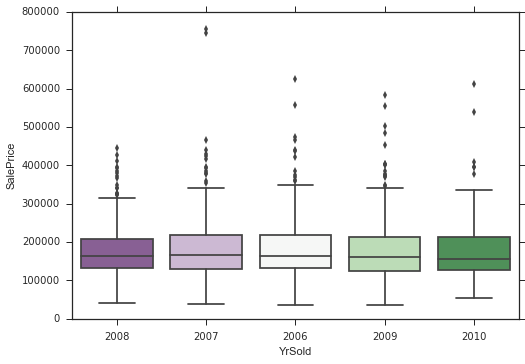

In [6]:
# plot year vs sale price, it looks like all the median sale prices are around the same.
import seaborn as sns
sns.set(style="ticks")
sns.boxplot(x='YrSold', y='SalePrice', data=train, palette="PRGn")

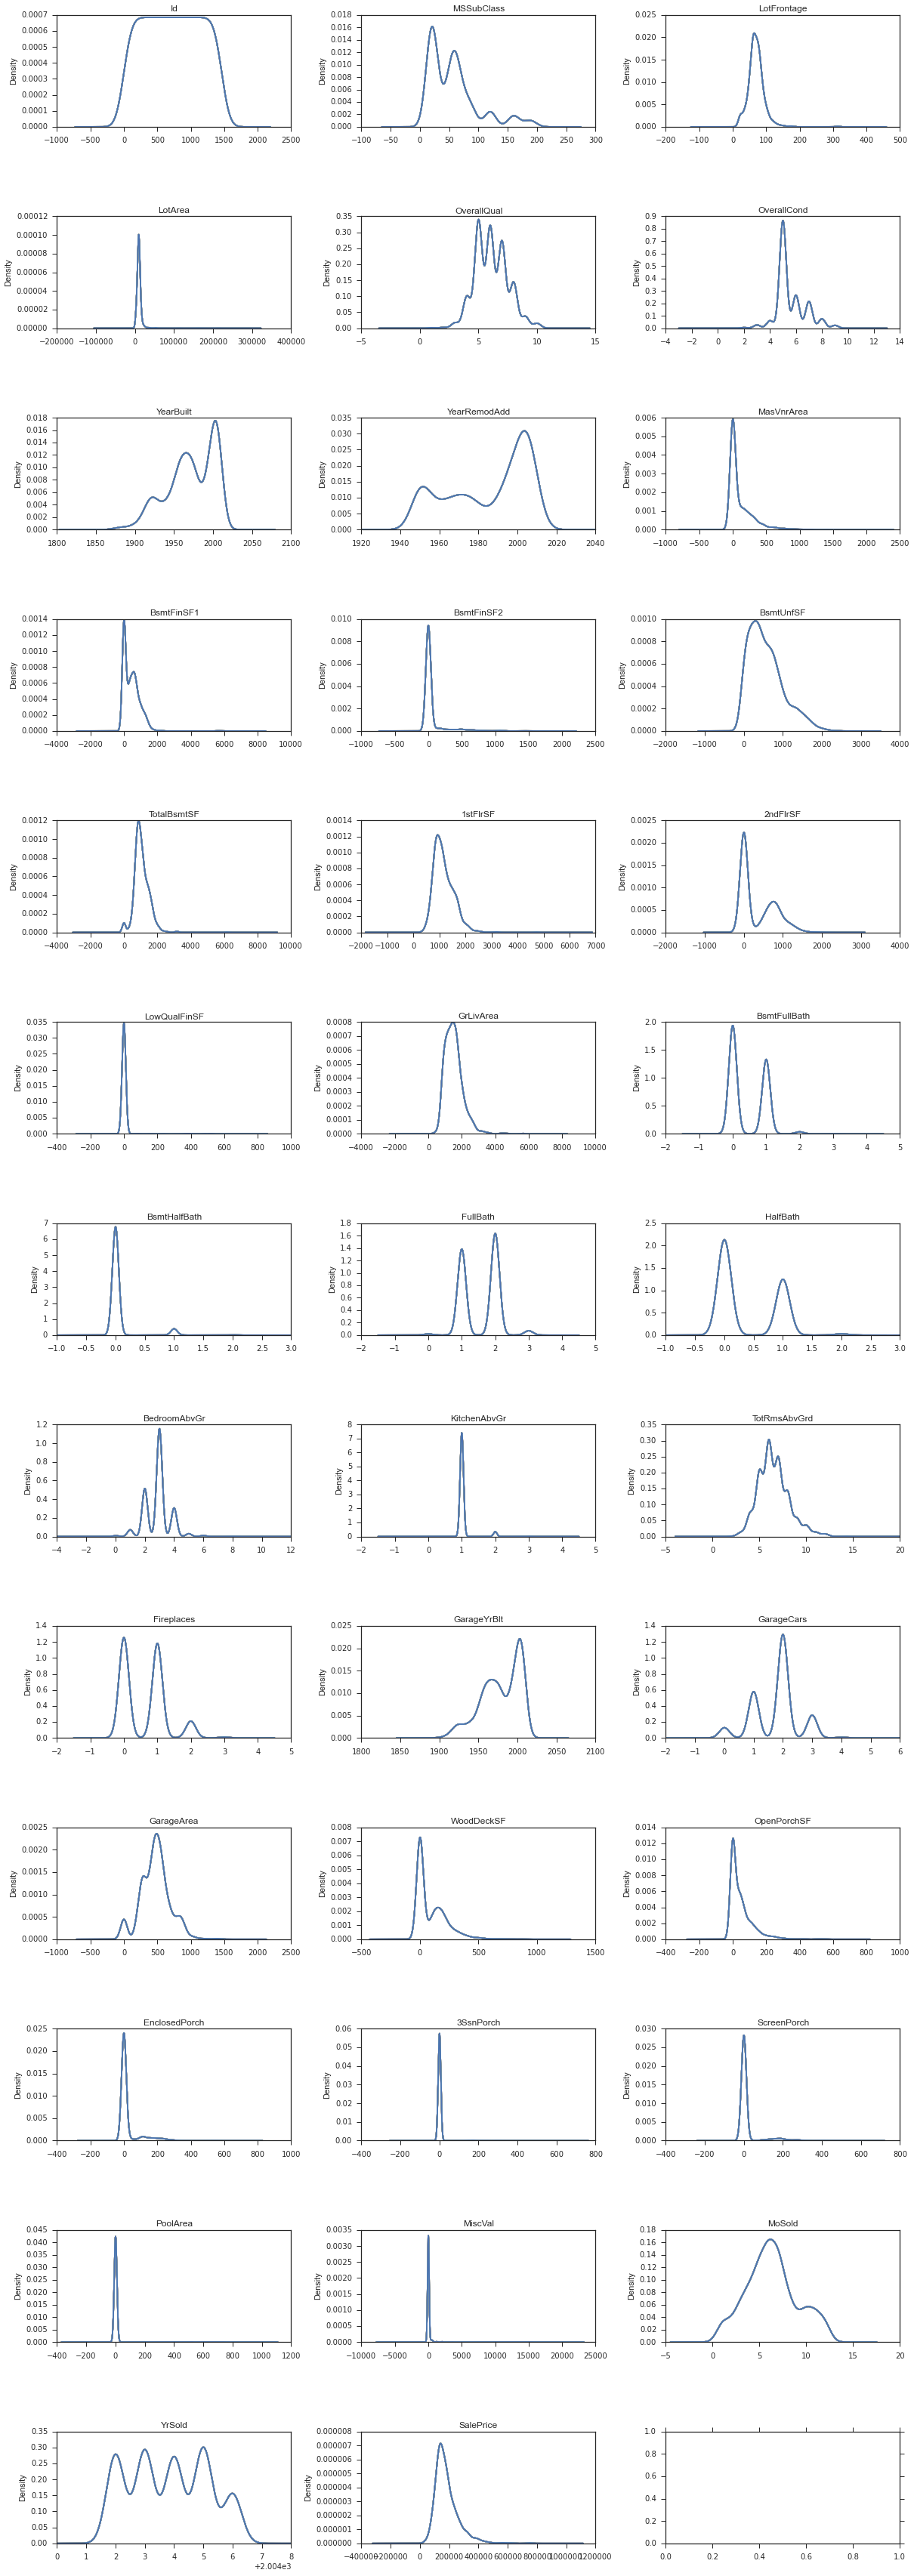

In [38]:
#number features

train.select_dtypes(include=['float64','int64'])
# num_features = train.dtypes[train.dtypes in ['int64','float64']].index
n_features1 = 10
n_rows = 13
num_df = train.select_dtypes(include=['float64','int64'])

fig, axs = plt.subplots(n_rows,3, figsize = (20,60))

fig.subplots_adjust(hspace=.8, wspace=.3)

for k in axs:
    for i,j in zip(num_df, axs.flat):
        g = num_df[i].plot.kde(ax = j, title = i)
        g.get_xaxis().tick_bottom()
        g.get_yaxis().tick_left()

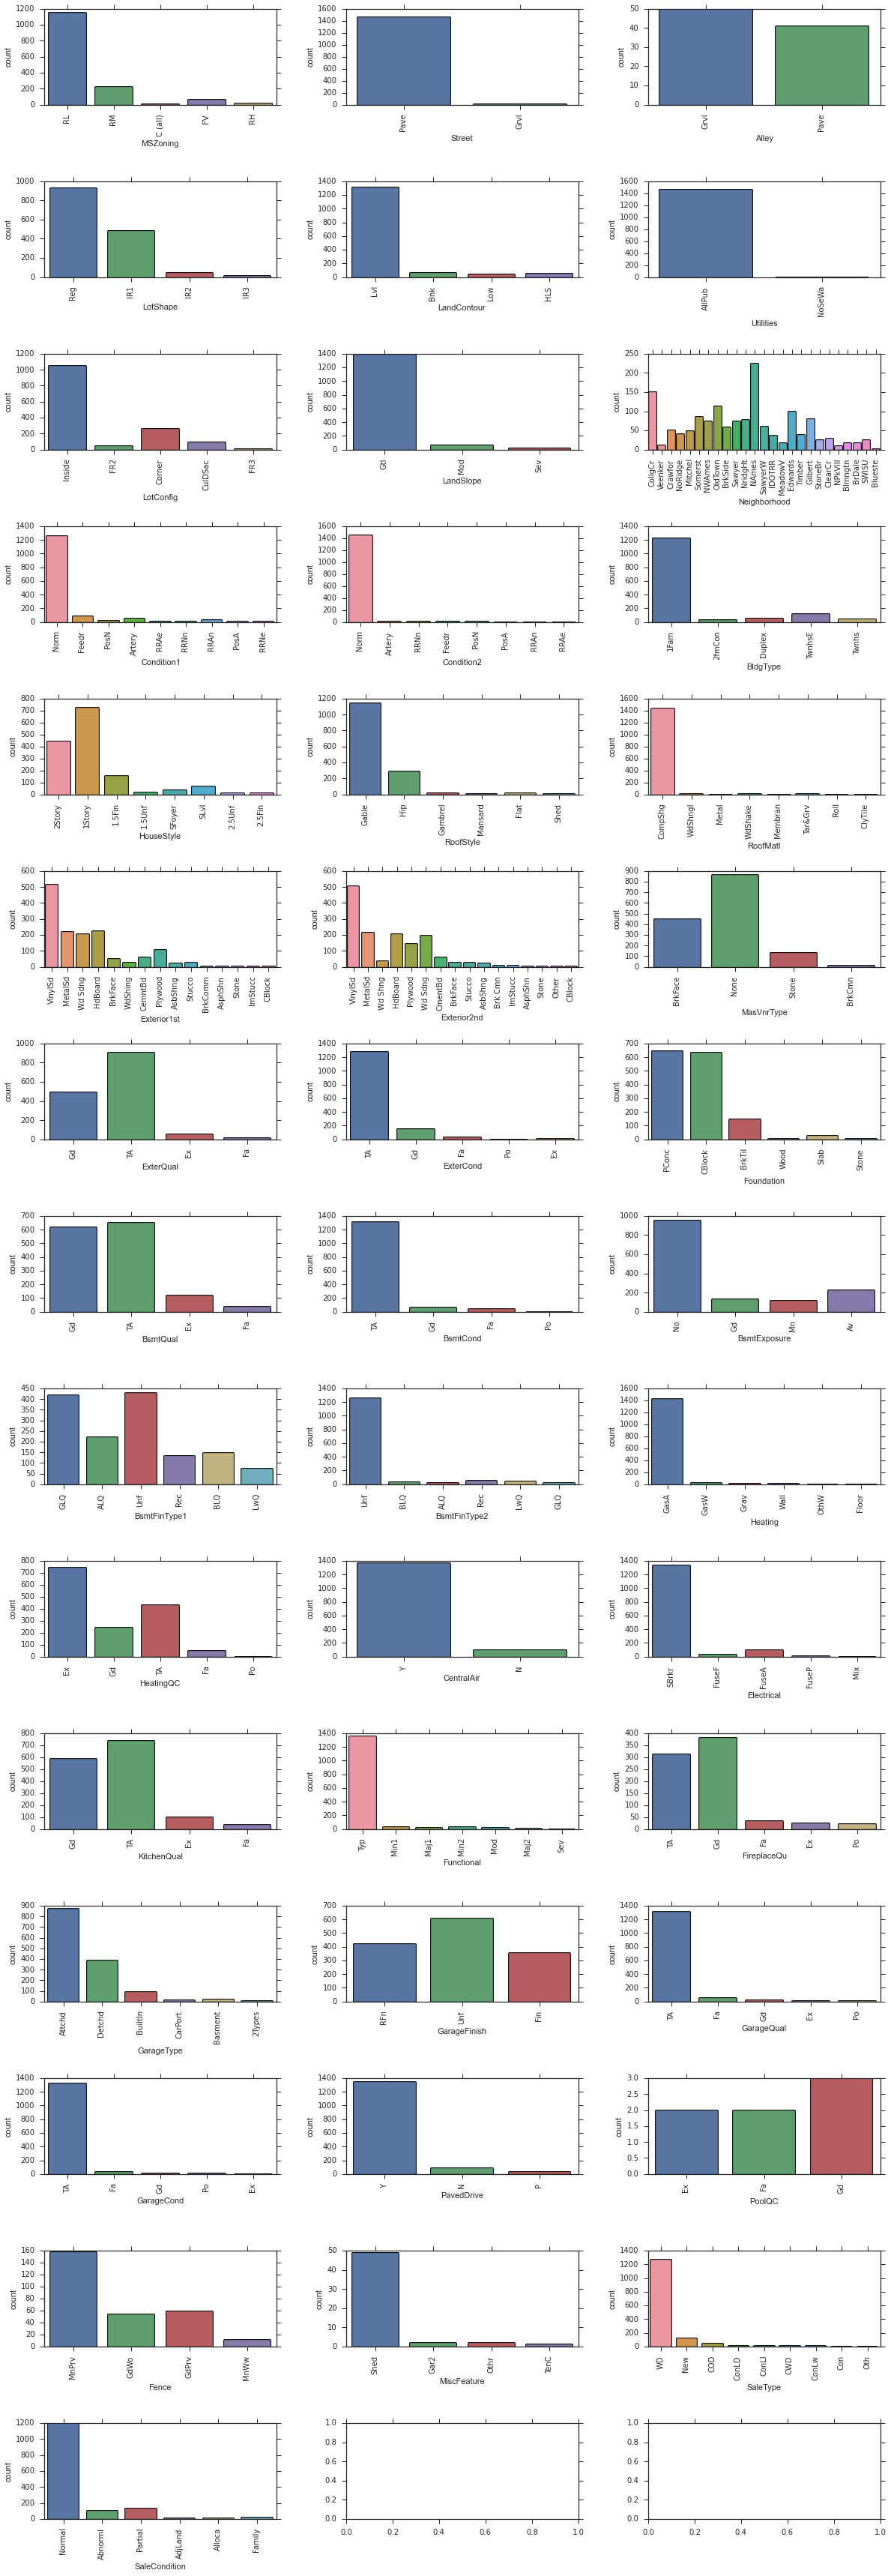

In [12]:
#object features
object_features = train.dtypes[train.dtypes == 'object'].index
n_features1 = 10
n_rows = 15
object_df = train[object_features]

fig, axs = plt.subplots(n_rows,3, figsize = (20,60))

fig.subplots_adjust(hspace=.8, wspace=.3)


for k in axs:
    for i,j in zip(object_features, axs.flat):
        g = sns.countplot(x=i, data=object_df, ax=j)
        plt.setp(j.get_xticklabels(), rotation=90)

In [41]:
# correlation plot with all numeric features
numeric_features = train.dtypes[train.dtypes != 'object'].index
pearson = train[numeric_features].corr(method='pearson')
corr_with_target = pearson.ix[-1][1:-1]
corr_with_target = corr_with_target[abs(corr_with_target).argsort()[::-1]]
print corr_with_target

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64


C:\Users\Moyp\dev\anaconda\lib\site-packages\seaborn-0.6.0-py2.7.egg\seaborn\linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
C:\Users\Moyp\dev\anaconda\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Moyp\dev\anaconda\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Moyp\dev\anaconda\lib\site-packages\seaborn-0.6.0-py2.7.egg\seaborn\linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


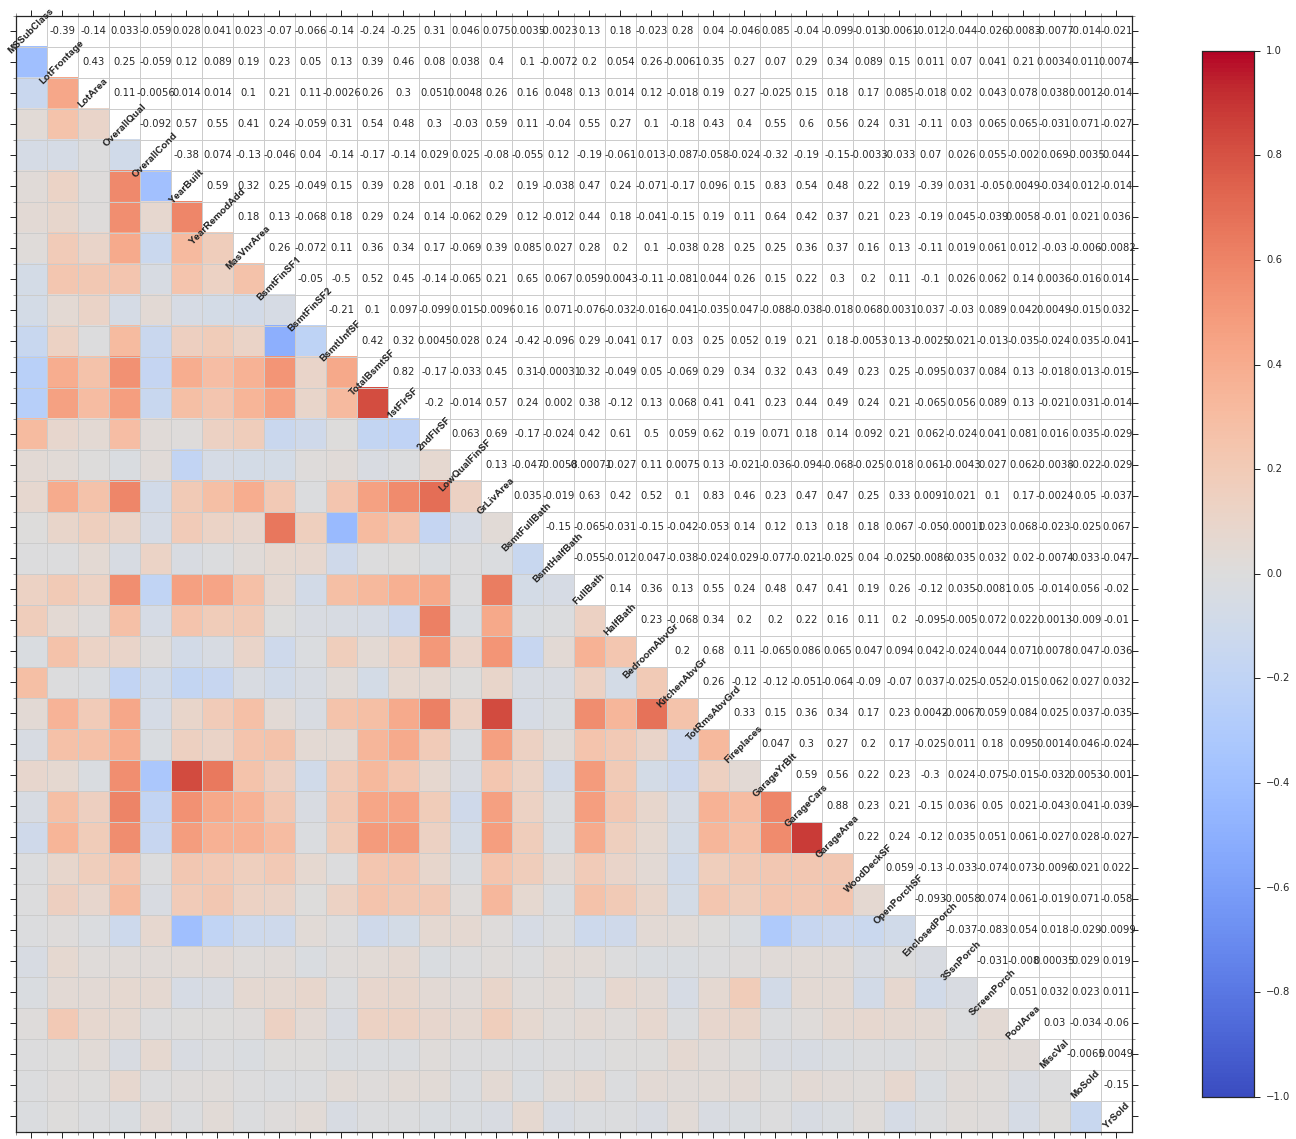

In [43]:
#TotalBsmtSF and 1stFlrSF have .82 correlation
#YearBuilt and GarageYrBlt have .83 correlation
#GrLivArea and TotRmsAbvGrd have .83 correlation
#GarageCars and GarageArea have .88 correlation
#BsmtFinSF2 and BsmtUntSF have -.5 correlation highest negative

# make a plot of specified dimension (in inches), just a 1x1 subplot
fig, ax = plt.subplots(figsize=(25, 25))
# pass the axis to draw on
sns.corrplot(train[numeric_features[1:-1]], ax=ax)

In [11]:
# Let's remove 1 of the 2 correlations with high correlation. This will avoid multicollinearity.
mc_columns = ['TotalBsmtSF', 'GarageYrBlt','TotRmsAbvGrd','GarageCars']
train.drop(mc_columns, axis = 1, inplace = True)
test.drop(mc_columns, axis = 1, inplace = True)

In [13]:
# columns with NAs and count
from __future__ import division
print "Train Columns with Nulls \n"
train_nulls = []
for column in train.columns:
    if train[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_nulls.append(column)
        
#test
test_nulls = []
print "\nTest Columns with Nulls \n"
for column in test.columns:
    if test[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_nulls.append(column)

Train Columns with Nulls 

Column: LotFrontage has 259 nulls which is 18.0%
Column: Alley has 1369 nulls which is 94.0%
Column: MasVnrType has 8 nulls which is 1.0%
Column: MasVnrArea has 8 nulls which is 1.0%
Column: BsmtQual has 37 nulls which is 3.0%
Column: BsmtCond has 37 nulls which is 3.0%
Column: BsmtExposure has 38 nulls which is 3.0%
Column: BsmtFinType1 has 37 nulls which is 3.0%
Column: BsmtFinType2 has 38 nulls which is 3.0%
Column: Electrical has 1 nulls which is 0.0%
Column: FireplaceQu has 690 nulls which is 47.0%
Column: GarageType has 81 nulls which is 6.0%
Column: GarageFinish has 81 nulls which is 6.0%
Column: GarageQual has 81 nulls which is 6.0%
Column: GarageCond has 81 nulls which is 6.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls 

Column: MSZoning has 4 nulls which is 0.0%
Column: LotFrontage has 227 nulls which is 16.0%
Column: Alley has 1

In [14]:
# there seems to be a lot of nulls in a lot of columns, lets put a 10% constraint on it,
# The train columns are equal to test columns. The percentages are about the same. Alley, PoolQC,
# Fence, and MiscFeature have a high percentage of nulls which means there is a lot of missing data.
# it is probably ok to drop these columns.

limit = .70
#train
train_nulls_less_70 = []
train_remove = []
print "Train Columns with Nulls > 70%\n"
for column in train_nulls:
    if float(train[column].isnull().sum()/len(train)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_remove.append(column)
    else:
        train_nulls_less_70.append(column)
        
#test
test_nulls_less_70 = []
test_remove = []
print "\nTest Columns with Nulls > 70%\n"
for column in test_nulls:
    if float(test[column].isnull().sum()/len(test)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_remove.append(column)
    else:
        test_nulls_less_70.append(column)

Train Columns with Nulls > 70%

Column: Alley has 1369 nulls which is 94.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls > 70%

Column: Alley has 1352 nulls which is 93.0%
Column: PoolQC has 1456 nulls which is 100.0%
Column: Fence has 1169 nulls which is 80.0%
Column: MiscFeature has 1408 nulls which is 97.0%


In [15]:
# remove the columns from train and test
train.drop(train_remove, axis = 1, inplace = True)
test.drop(test_remove, axis = 1, inplace = True)

In [16]:
print train_nulls_less_70
#Electrical null is not part of factors
train_columns_true_null = {'Electrical':['Utilities','YearBuilt','Heating','HeatingQC','CentralAir']}
train_columns_null = [item for item in train_nulls_less_70 if item not in train_columns_true_null.keys()]

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [17]:
# replace the train null columns
for column in train_columns_null:
    if train[column].dtype == 'float64':
        train.ix[train[column].isnull(), column] = 0
    else:
        train.ix[train[column].isnull(), column] = 'None'

In [18]:
print test_nulls_less_70
#null not part of factors
test_columns_true_null = {'MSZoning':['LotShape','LandContour','LandSlope','Neighborhood'],
                          'Utilities':['YearBuilt','Heating','HeatingQC','CentralAir'],
                          'Exterior1st':['RoofStyle','MasVnrType','Foundation'],
                          'Exterior2nd':['RoofStyle','MasVnrType','Foundation'],
                          'KitchenQual':['OverallQual','OverallCond','Functional'],
                          'Functional':['KitchenQual','OverallQual','OverallCond']}
test_columns_null = [item for item in test_nulls_less_70 if item not in test_columns_true_null.keys()]
#SaleType (change to Other)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


In [19]:
# replace the test null columns
for column in test_columns_null:
    if test[column].dtype == 'float64':
        test.ix[test[column].isnull(), column] = 0
    elif column == 'SaleType':
        test.ix[test[column].isnull(), column] = 'Oth'
    else:
        test.ix[test[column].isnull(), column] = 'None'

### Find Nulls and Replace
The function below replaces the nulls values that are not part of the column's categories. For example Electrical has the following categories:

    SBrkr	Standard Circuit Breakers & Romex
    FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
    FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
    FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
    Mix	Mixed

a null will be just be a missing data point. I will find columns relevant to the null value's column in question. I will take the values for the relevant columns associated with the null value and find existing observations with the same values. If they are match I will record it and in the end take the value with the most occurences and set the null value as it.

In [20]:
def find_nulls_and_similar_then_replace(df, null_column, rel_columns):
    #try to find similar obsverations like null MSZoning
    null_values = df[df[null_column].isnull()]\
    [rel_columns].values

    num_nulls = len(null_values) #number of nulls
    num_rel_columns = len(rel_columns) #number of relevant columns

    not_null_values = df[df[null_column].notnull()]\
    [rel_columns]

    similar_values = {sec : [] for sec in range(0,num_nulls)}#index of similar no null values to null values

    for key, values in enumerate(null_values):
        for index, row in not_null_values.iterrows(): #iterate over all rows
            if (row.values == values).sum() >= (num_rel_columns - 1): #if greater than equal to num_rel_columns - 1 
                similar_values[key].append(df.ix[index,null_column]) #append to list

    replace_nulls(df, null_column, similar_values)

In [21]:
from collections import Counter

def replace_nulls(df, column, similar_values):
    
    most_common_value = []
    
    for key in similar_values:
        most_common_value.append(Counter(similar_values[key]).most_common(1)[0][0]) #most common value is appended to list

    df.ix[df[column].isnull(),column] = most_common_value #replace nulls

In [22]:
#Train
for key, value in train_columns_true_null.iteritems():
    find_nulls_and_similar_then_replace(train,key,value)

In [23]:
#Test - MSZoning
for key, value in test_columns_true_null.iteritems():
    find_nulls_and_similar_then_replace(test,key,value)

In [24]:
#lets see if it worked, it did!
print train.isnull().values.any()
print test.isnull().values.any()

False
False


In [25]:
#reset the x y variables
train_x = train.ix[:,:-1]
train_y = train.ix[:,-1]

train_x.columns == test.columns #check columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [26]:
# check if objects have the same number of categories
train_objects = train.dtypes[train.dtypes=='object'].index
test_objects = test.dtypes[test.dtypes=='object'].index

print train_objects == test_objects
for column in train_objects:
    if len(train[column].unique()) != len(test[column].unique()):
        print column, train[column].unique(), test[column].unique()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Utilities ['AllPub' 'NoSeWa'] ['AllPub']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll' 'ClyTile'] ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock'] ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' 'CBlock']
Exterior2nd ['VinylSd' 'MetalSd' 'Wd Shng

## Machine Learning

In [27]:
def dummy_transform(df):
    # create dummy columns 
    object_columns = df.columns[df.dtypes == 'object']
    #print object_columns.shape
    object_dummies = pd.get_dummies(df[object_columns], drop_first = False)
    #print object_dummies.shape
    
    # new dataframe 
    new_train_x = pd.concat([df, object_dummies], axis=1)
    nonobject_columns = new_train_x.columns[new_train_x.dtypes != "object"]
    #print nonobject_columns.shape
    nonobject_columns = nonobject_columns[1:] # removed id
    new_train_x = new_train_x[nonobject_columns]
    
    return(new_train_x)

In [28]:
# Dummy columns after test transformation, find columns that are the same in both sets
def train_test_same_columns(train_df,test_df):
    test = dummy_transform(test_df) #dummy
    train = dummy_transform(train_df) #dummy

    final_columns = test.columns & train.columns #only columns that match
    
    return train[final_columns],test[final_columns]

In [29]:
train_x_dum, test_dum = train_test_same_columns(train_x,test)

In [30]:
from sklearn.metrics import mean_squared_error as mse
def error_metric(y_true,y_pred):
    
    error = np.sqrt(mse(y_true,y_pred))
    
    return error

In [84]:
# create train and test set and run lm model
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(train_x_dum, train_y, test_size=0.20, random_state=0) #split set

In [83]:
#linear regression
lm = LinearRegression() 

#train on train set
lm.fit(X_train,y_train)

#coefficients
coef_df = pd.DataFrame({'features':X_train.columns, 'coef':lm.coef_})[['features','coef']]
print coef_df.sort_values(['coef'], ascending=[False])[:10] #high coef
print coef_df.sort_values(['coef'], ascending=[True])[:10] #low coef

#pred
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)
print "\n"
print "Train RMSE:",error_metric(y_train,pred_train)
print "Test RMSE:", error_metric(y_test,pred_test)
print "\n"

                 features           coef
93        Condition2_PosA  148969.152081
92        Condition2_Norm  118595.646582
90      Condition2_Artery  115205.743152
91       Condition2_Feedr  110868.428262
112        RoofStyle_Shed   64151.839275
251          SaleType_CWD   50654.904736
172           BsmtCond_Po   43107.741869
135   Exterior2nd_CmentBd   41606.611614
256          SaleType_New   37561.941418
78   Neighborhood_StoneBr   34532.128890
                  features           coef
94         Condition2_PosN -330948.553422
239          GarageQual_Po -133143.274734
236          GarageQual_Fa -125309.248422
240          GarageQual_TA -123562.544967
237          GarageQual_Gd -120337.844773
241          GarageCond_Ex  -86093.960460
114       RoofMatl_Tar&Grv  -42189.037912
264  SaleCondition_Partial  -36655.697052
115       RoofMatl_WdShake  -36216.941472
55           LandSlope_Sev  -28770.017103


Train RMSE: 18758.2439513
Test RMSE: 56763.3842889




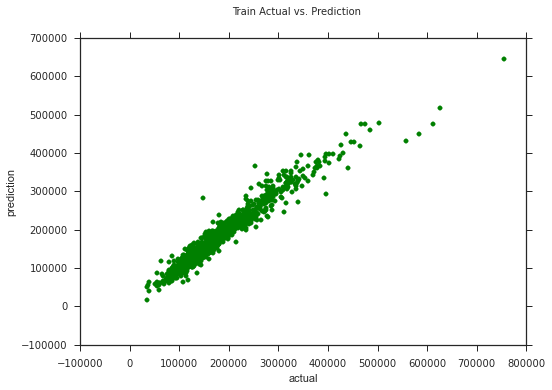

In [32]:
# Train actual vs prediction
plt.scatter(y_train, pred_train,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Train Actual vs. Prediction')

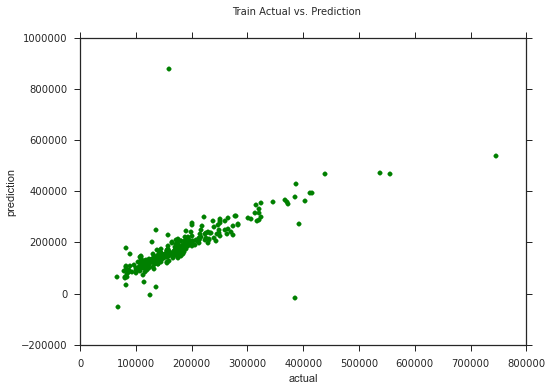

In [33]:
#Test actual vs prediction
plt.scatter(y_test, pred_test,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Train Actual vs. Prediction')

(0, 550000)

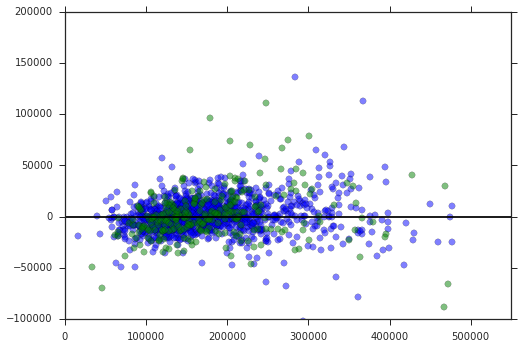

In [34]:
#residual plot - based on the residual plot there is some heteroscedasticity meaning the residuals get larger as the prediction
#moves from small to large or vice versa.
#to fix there might be a variable that needs to be transformed or a variable is missing. Since we used all the variables
#lets look at a transforming variables into more a bell shape.
plt.scatter(pred_train, pred_train - y_train, c = 'b', s = 40, alpha = .5)
plt.scatter(pred_test, pred_test - y_test, c = 'g', s = 40, alpha = .5)
plt.hlines(y = 0, xmin = 0, xmax = 550000)
plt.ylim(-100000,200000)
plt.xlim(0,550000)

In [35]:
#ridge regression (.16 score)
from sklearn.linear_model import Ridge
rlm = Ridge(alpha=1.0)


#train on train set
rlm.fit(X_train,y_train)

#coefficients
coef_df = pd.DataFrame({'features':X_train.columns, 'coef':rlm.coef_})[['features','coef']]
print coef_df.sort_values(['coef'], ascending=[False])[:10] #high coef
print coef_df.sort_values(['coef'], ascending=[True])[:10] #low coef

#pred
pred_train = rlm.predict(X_train)
pred_test = rlm.predict(X_test)
print "\n"
print "Train RMSE:",error_metric(y_train,pred_train)
print "Test RMSE:", error_metric(y_test,pred_test)
print "\n"

                 features          coef
92        Condition2_Norm  60382.111334
91       Condition2_Feedr  41444.877758
116      RoofMatl_WdShngl  37685.057446
78   Neighborhood_StoneBr  34664.676551
93        Condition2_PosA  31881.133259
71   Neighborhood_NoRidge  31254.571720
90      Condition2_Artery  26167.096922
251          SaleType_CWD  25403.034708
112        RoofStyle_Shed  24416.710686
256          SaleType_New  22040.536700
                  features           coef
94         Condition2_PosN -163414.330343
114       RoofMatl_Tar&Grv  -24283.048575
264  SaleCondition_Partial  -20741.042850
32        MSZoning_C (all)  -20342.732835
113       RoofMatl_CompShg  -18617.381775
55           LandSlope_Sev  -18457.966135
236          GarageQual_Fa  -18412.919197
240          GarageQual_TA  -18081.633657
63    Neighborhood_Edwards  -17982.950870
67    Neighborhood_Mitchel  -16396.363737


Train RMSE: 19900.740454
Test RMSE: 48839.3582391




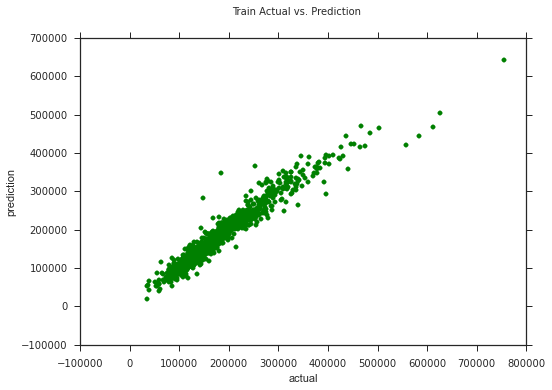

In [36]:
# Train actual vs prediction
plt.scatter(y_train, pred_train,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Train Actual vs. Prediction')

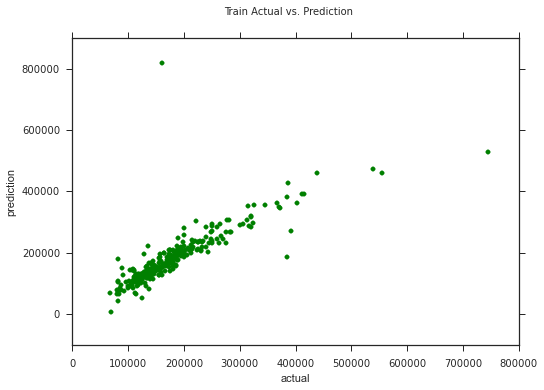

In [37]:
#Test actual vs prediction
plt.scatter(y_test, pred_test,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Train Actual vs. Prediction')

In [38]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [39]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear'}
optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                             scoring = 'mean_squared_error', cv = 5, n_jobs = -1)


In [ ]:
optimized_GBM.fit(X_train, y_train)

In [41]:
optimized_GBM.grid_scores_

[mean: -719640090.80399, std: 193637068.53832, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: -716502719.69023, std: 240709498.46707, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: -755886088.08133, std: 238464063.57012, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: -784051659.31797, std: 224265522.81316, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: -765736082.15277, std: 271187757.41827, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: -826091178.63004, std: 248231003.08334, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: -739080273.78575, std: 170543044.30913, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: -801764128.06475, std: 261601522.87378, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: -856770715.28996, std: 309675860.41462, params: {'max_depth': 7, 'min_child_weight': 5}]

In [39]:
#grid search on learning rate
cv_params = {'learning_rate': [0.1, 0.01, 0.05]}
ind_params = {'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear', 'max_depth':3, 'min_child_weight': 3}
optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                             scoring = 'mean_squared_error', cv = 5, n_jobs = -1)
optimized_GBM.fit(train_x_dum, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [40]:
optimized_GBM.grid_scores_

[mean: -716502719.69023, std: 240709498.46707, params: {'learning_rate': 0.1},
 mean: -741680481.33880, std: 213980739.81896, params: {'learning_rate': 0.01},
 mean: -696792035.92220, std: 219604682.44099, params: {'learning_rate': 0.05}]

based on cv

- learning_rate = 0.05
- subsample = 0.8
- max_depth = 3
- min_child_weight = 3

To increase the performance of XGBoost’s speed through many iterations of the training set, and since we are using only XGBoost’s API and not sklearn’s anymore, we can create a DMatrix. This sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient. This is especially helpful when you have a very large number of training examples. To create a DMatrix:

In [42]:
xgdmat = xgb.DMatrix(train_x_dum, train_y)

Now let’s specify our parameters (with slightly different syntax in some places for the XGBoost native API) and set our stopping criteria. For now, let’s be aggressive with the stopping and say we don’t want the accuracy to improve for at least 100 new trees.

In [44]:
our_params = {'eta': 0.05, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear', 'max_depth':3, 'min_child_weight':3} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['rmse','error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

We can look at our CV results to see how accurate we were with these settings. The output is automatically saved into a pandas dataframe for us.

In [47]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,test-rmse-mean,test-rmse-std,train-error-mean,train-error-std,train-rmse-mean,train-rmse-std
892,-180920.2,6797.554051,25229.751172,3867.189447,-180920.196875,1699.387815,6627.580859,177.878707
893,-180920.2,6797.554051,25230.403516,3868.996771,-180920.196875,1699.387815,6622.261817,177.699469
894,-180920.2,6797.554051,25230.897266,3871.289679,-180920.196875,1699.387815,6617.433008,177.570104
895,-180920.2,6797.554051,25230.794922,3870.067278,-180920.196875,1699.387815,6612.397070,178.651338
896,-180920.2,6797.554051,25228.218750,3869.515954,-180920.196875,1699.387815,6607.494336,177.829138


Our CV mse at 896 iterations is 25228^2 = 636451984

Now that we have our best settings, let’s create this as an XGBoost object model that we can reference later.

In [50]:
our_params = {'eta': 0.05, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear', 'max_depth':3, 'min_child_weight':3} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 896)

Notice that it trains very quickly. With our XG model object, we can then plot our feature importances using a built-in method. This is similar to the feature importances found in sklearn.

In [79]:
#plot top 20 important
importance = final_gb.get_fscore()
importance_df = pd.DataFrame({'feature':list(importance.keys()), 'f-score':list(importance.values())})
importance_df = importance_df.sort_values('f-score')[-20:]
importance_df


,f-score,feature
183,54,ScreenPorch
179,58,BsmtFinSF2
74,74,YrSold
10,77,EnclosedPorch
155,121,MasVnrArea
52,122,OverallCond
112,137,MoSold
50,140,2ndFlrSF
153,141,WoodDeckSF
9,143,YearRemodAdd


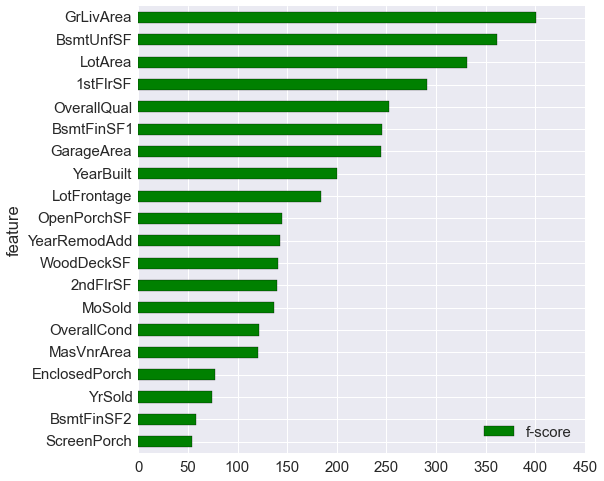

In [82]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

importance_df.plot(kind = 'barh', x = 'feature', figsize = (8,8), color = 'green')

In [55]:
test_id = test.iloc[:,0]
pred = optimized_GBM.predict(test_dum)

In [57]:
submission = pd.DataFrame({'Id':test_id,'SalePrice':pred})
submission.loc[submission['SalePrice']<0,'SalePrice'] = 0
submission.to_csv('xgb_submission_cv.csv',index = False)